## Trabajo Practico 1

## Integrantes:
Martin Leon Cuadrado Bertollo : 824/23

Segundo Sacchi : 434/23

Lucas Petersen Frers : 1149/23

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

In [3]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [4]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

# Resolución del TP


## Punto 1:

> Muestre que el vector de rankings $p$ es solución de la ecuación
$M \cdot p = b$, con $M = \frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)$ y $b$ = 1

Partamos de la ecuacion siguiente para llegar hacia $M \cdot p = b$:

$$
p = (1 - \alpha) \cdot C \cdot p + \frac{\alpha}{N} \cdot 1_v
$$
$$
0 = (1 - \alpha) \cdot C \cdot p - p + \frac{\alpha}{N} \cdot 1_v
$$
$$
- \frac{\alpha}{N} \cdot 1_v = (1 - \alpha) \cdot C \cdot p - p
$$
Aca sacamos factor comun usando $p$ 
$$
- \frac{\alpha}{N} \cdot 1_v = ((1 - \alpha) \cdot C - I) \cdot p 
$$
$$
\frac{\alpha}{N} \cdot 1_v = -((1 - \alpha) \cdot C - I) \cdot p 
$$
$$
\frac{\alpha}{N} \cdot 1_v = (I - (1 - \alpha) \cdot C) \cdot p 
$$
$$
1_v = \frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C) \cdot p   
$$
Por la definicion de $M$ simplemente reemplazamos y llegamos a:
$$
1_v = M \cdot p   
$$
Entonces llegamos que el vector de rankings $p$ es el resultado de $M \cdot p = b$ con $b = 1_v$

## Punto 2:


> ¿Qué condiciones se deben cumplir para que exista una única solución a la ecuación del
punto anterior?
>

 Para que $M \cdot p = b$ tenga una sola solucion las columnas de $M$ deberian ser linealmente independientes.

> ¿Se cumplen estas condiciones para la matriz M tal como fue construida
para los museos, cuando 0 < α < 1?



Sabemos que:
$$
M = \frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)
$$
Donde $\frac{N}{\alpha}$ es un escalar, $N$ es el tamaño de $C$ y $\alpha$ un numero mayor 0 y menor estricto que 1, por lo que verdaderamente nos interesa ver para convencernos de que la matriz $M$ tiene solucion unica es la parte de:
$$
(I - (1 - \alpha) \cdot C)
$$
Lo que sabemos de esta parte de la formula es que (por la definicion de dada anteriormente)
$$
0 < (1 - \alpha) < 1
$$

Luego, sobre $C$ sabemos que es una matriz estocastica, esto quiere decir que:

$$
\sum_{j=1}^{n} C_{ij} = 1 \quad \forall\, i \in \{1, \dots, n\} \quad \land \quad C_{ij} \geq 0 \quad \forall\, i, j \in \{1, \dots, n\}
$$

Entonces,
$$
0 \leq C_{ij} \leq 1 \quad \forall\, i, j \in \mathbb{Z},\ 1 \leq i,j \leq n
$$

Ahora bien, teniendo esta informacion como podriamos demostrar que la Matriz $M$ tiene solucion unica?

Sea $B \in \mathbb{R}^{n \times n}$ tal que...
$$
B = (1-\alpha) \cdot C \\
$$
Puedo deducir que
$$
\text{como} \quad 0 < (1 - \alpha) < 1 \quad \land \quad \sum_{j=1}^{n} C_{ij} = 1 \quad \forall\, i \in \{1, \dots, n\} \quad \Rightarrow \sum_{j=1}^{n} B_{ij} < 1 \quad \forall\, i \in \{1, \dots, n\} 
$$

Luego,
$$
\|\mathbf{B}\|_1 < 1
$$
Teniendo esto en cuenta, tratemos de definir por absurdo que el resultado de la $(I - B)$ es inversible, es decir, que es sus columnas son linealmente independientes y por lo tanto existe un único resultado para $M \cdot p = b$. 

Supongamos que el resultado de dicha resta NO tiene columnas linealmente independientes, esto significa que

$$
\dim\left( \text{Nu}(I - B) \right) > 0
$$

pues tendremos valores ademas del $x = 0$ para los cuales:

$$
(I - B) \cdot \mathbf{x} = \mathbf{0} 
$$
Por lo tanto podemos asegurar que existe un $x != 0$ para el cual el resultado de dicha ecuacion es 0. Por lo cual podemos plantear que:
$$
(I - B)\cdot \mathbf{x} = \mathbf{0} 
$$ 
$$
I\cdot \mathbf{x} - B\cdot \mathbf{x} = 0 
$$ 
$$
\mathbf{x} - B\cdot \mathbf{x} = 0
$$
$$
\mathbf{x} = B\cdot \mathbf{x}
$$
Y terminamos llegando a una igualdad:
$$
\|\mathbf{x}\|_1 = \|\mathbf{Bx}\|_1 
$$
Por propiedad de normas, podemos definir que:
$$
\|\mathbf{Bx}\|_1 \leq \|\mathbf{B}\|_1 \cdot \|\mathbf{x}\|_1 
$$
Y ahora reemplazamos
$$
\|\mathbf{x}\|_1 \leq \|\mathbf{B}\|_1 \cdot \|\mathbf{x}\|_1 
$$
$$
1 \leq \|\mathbf{B}\|_1
$$
ABSURDO! sabiamos que $\|\mathbf{B}\|_1 < 1$, este error se debe en que asumimos que $(I - B)$ no era inversible, por lo que al demostrar que la matriz resultado de esta resta es inversible, podemos asegurar que $M$ es inversible.

## Punto 3:

>  Encuentre el vector $p = M^{-1} \cdot b$ en los siguientes casos:

In [5]:
#Seteamos las variables que sabemos que son globales y no cambian
N = A.shape[0]
I = np.eye(N, k=0)

#Funciones que utilizamos


# Aca realizamos la factorizacion (sin pivoteo) de una matriz cuadrada haciendo las transformaciones fila a fila llenando de 0's 
# debajo de la diagonal, y luego guardando allí la iteración de L_i, este se estará corriendo para guardar en la misma matriz
# el L y el U. Luego se separan ambas triangulaciones superiores e inferiores y se retornan

def elim_gaussiana(A):
    m=A.shape[0]
    n=A.shape[1]
    Ac = A.copy()
    
    if m!=n:
        print('Matriz no cuadrada')
        return
    
    for iteracion in range(n - 1):
        for fila in range(iteracion + 1, n):
            divisor = Ac[fila][iteracion] / A[iteracion][iteracion]
            Ac[fila][iteracion] = divisor  
            
            for columna in range(iteracion + 1, n):  
                Ac[fila][columna] = Ac[fila][columna] - divisor * Ac[iteracion][columna]
            
    L = np.tril(Ac,-1) + np.eye(n)
    U = np.triu(Ac)
    
    return L, U

# Resuelve L*y = b, con L siendo matriz triangular inferior

def y_calculator(L, b):
    return scipy.linalg.solve_triangular(L, b, lower=True)

# Resuelve U*x = y, con U siendo matriz triangular superior

def x_calculator(U, y):
    return scipy.linalg.solve_triangular(U, y, lower=False)


def matriz_M(a,m):
    # Armamos K que es la identidad multiplicada por m. Como necesitamos la inversa solamente calculamos la inversa de la diagonal
    K_inversa = np.eye(N, k=0)*(1/m)
    # Construimos A para el m indicado
    A_m = construye_adyacencia(D, m)
    A_transpueta = A_m.T
    
    C_m = A_transpueta @ K_inversa
    # Devolvemos la definicion de M 
    M = (N/a)*(I-(1-a)*C_m)
    return M

def ploteador(p, m, ax =None):
    A_m = construye_adyacencia(D, m)
    G_m = nx.from_numpy_array(A_m) # Construimos la red a partir de la matriz de adyacencia
    G_m_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    # Construimos un layout a partir de las coordenadas geográficas
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    p = p/p.sum() # Normalizamos para que sume 1
   
    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(p)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G_m.nodes)} # Nombres para esos nodos
   
    nx.draw_networkx(G_m, G_m_layout, node_size = p*factor_escala, ax=ax, with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G_m, G_m_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

def plot_page_rank_usando_m_o_alpha(set_museos, vectores_ranking, label_x, title, arguments_for_plot):
    plt.figure(figsize=(12,6))
    for museo in list(set_museos):
        valores_p = [p[museo] for p in vectores_ranking]
        plt.plot(arguments_for_plot, valores_p, marker='o', label=f'Museo {museo}')

    plt.xlabel(label_x)
    plt.ylabel("PageRank")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
# Aca seteamos los alpha's y m's para generar todas las matrices M que nos piden, luego vamos a obtener la 
# factorizacion LU de cada una y resolvemos con las funciones para las matrices trianguladas
# Tambien seteamos el vector b lleno de 1's

alpha_6_7 = 6/7
alpha_4_5 = 4/5
alpha_2_3 = 2/3
alpha_1_2 = 1/2
alpha_1_3 = 1/3
alpha_1_5 = 1/5
alpha_1_7 = 1/7

m_1 = 1
m_3 = 3
m_5 = 5
m_10 = 10

b = np.ones(N)

Por último, antes de comenzar queremos demostrar qué es lo que estamos implementando en código y para qué lo estamos realizando.

El procedimiento es el siguiente:

Queremos encontrar $M$ tal que
$$
M = \frac{N}{\alpha} \cdot (I - (1 - \alpha) \cdot C)
$$
Para eso, calculamos $C$ tal que:
$$
C = A^{t} \cdot K^{-1}
$$


$A$ es la matríz de adyacencias construída por $D$ y $m$, siendo $m$ la cantidad de vecinos cercanos a considerar para relacionar los museos y $D$  la matríz que contiene en el elemento $D_{ji}$ la distancia entre los museos $j$ e $i$.

$K$ es la matriz identidad multiplicada por los $m$ vecinos.

Una vez calculado $M$, resolveremos:
$$
M^{-1}b = p
$$
En vez de calcular la $M^{-1}$ utilizaremos la factorizacion $LU$ de $M$.
$$
M = L \cdot U
$$

Luego, desarrollamos el siguiente sistema:
$$
M^{-1}b = p
$$
$$
M \cdot p = b
$$
$$
L\cdot U \cdot p = b
$$
Si definimos $y$ tal que 
$$
U \cdot p = y
$$
Podremos encontrar $p$ mediante operaciones con matrices trianguladas.

La estrategia consisten en encontrar $y$ resolviendo el sistema
$$
L \cdot y = b
$$
y finalmente encontrar $p$ resolviendo
$$
U \cdot p = y
$$


De esta forma, obtenemos el vector de rankings $p$ para esa matriz $M$ en particular.




### Ejercicio A


> Construyendo la red conectando a cada museo con sus $m$ = 3 vecinos más cercanos,
calculen el Page Rank usando $\alpha$ = $\frac{1}{5}$. Visualizen la red asignando un tamaño a
cada nodo proporcional al Page Rank que le toca

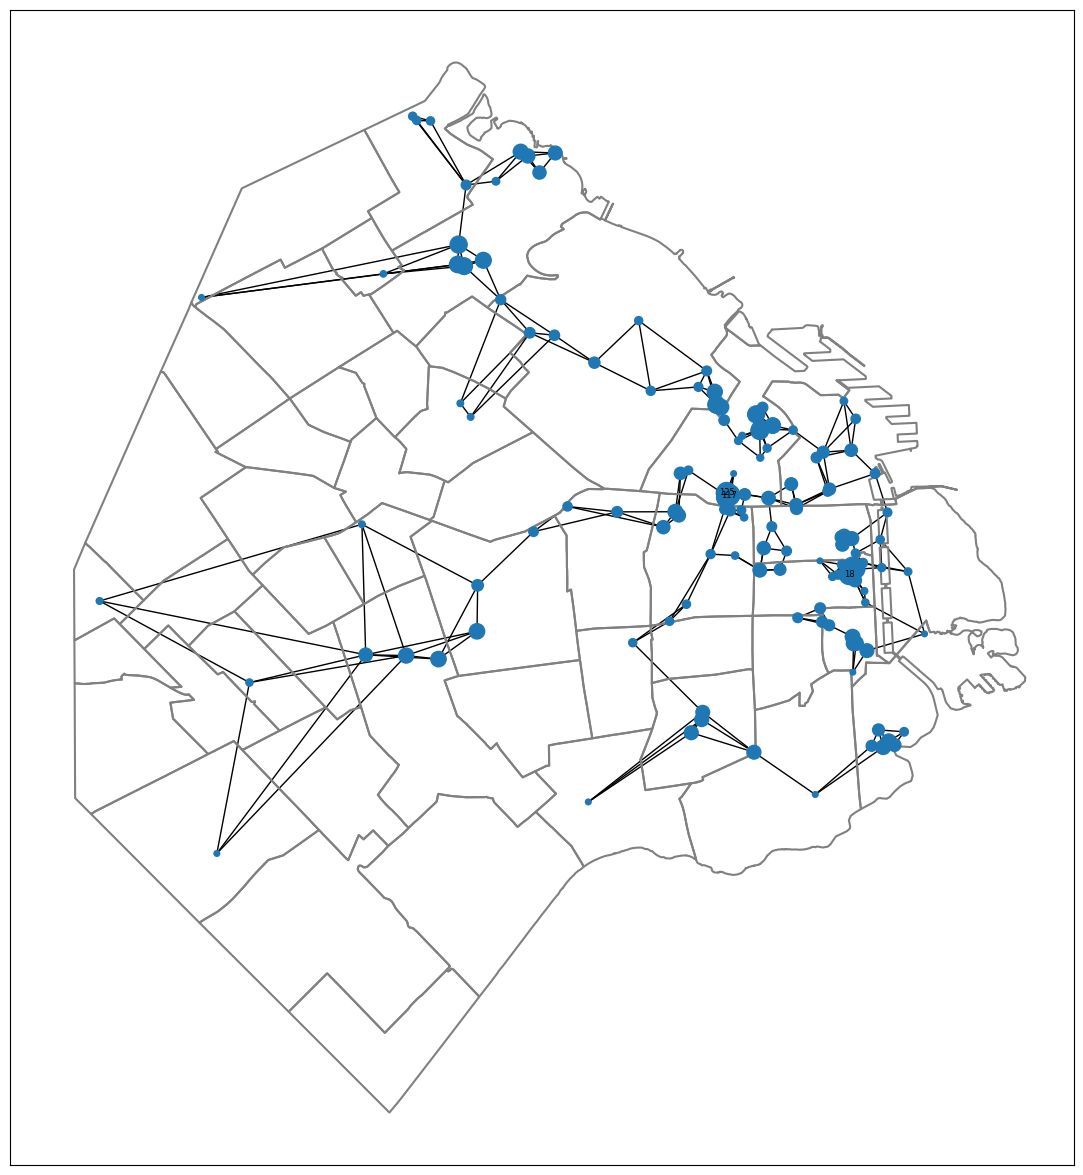

In [7]:
#Ahora si, armamos la primer Matriz M pedida en a)

# Aca calculamos el M particular para el m y alpha fijos, calculamos su factorizacion LU y resolvemos las dos
# triangulaciones que nos quedan, finalmente lo ploteamos

M = matriz_M(alpha_1_5, m_3)
L, U = elim_gaussiana(M)
y = y_calculator(L, b)
p = x_calculator(U, y)
ploteador(p, m_3)



Dejando fijos los parámetros $m$ = 3 y $\alpha = \frac{1}{5}$, podemos observar que los museos con mayor PageRank son aquellos que se encuentran más cercanos a otros.
Esto tiene sentido pues $\alpha$ tiene un valor bajo, lo cual determina que el valor del PageRank se verá afectado con mayor peso por la cercanía del museo (reducimos la "aleatoreidad"). 
Es por eso que aquellos museos que se encuentran entre muchos otros se observan beneficiados.

### Ejercicio B

> Construyendo la red conectando a cada museo con sus m vecinos más cercanos,
para $m$ = 1, 3, 5, 10 y usando $\alpha = \frac{1}{5}$.

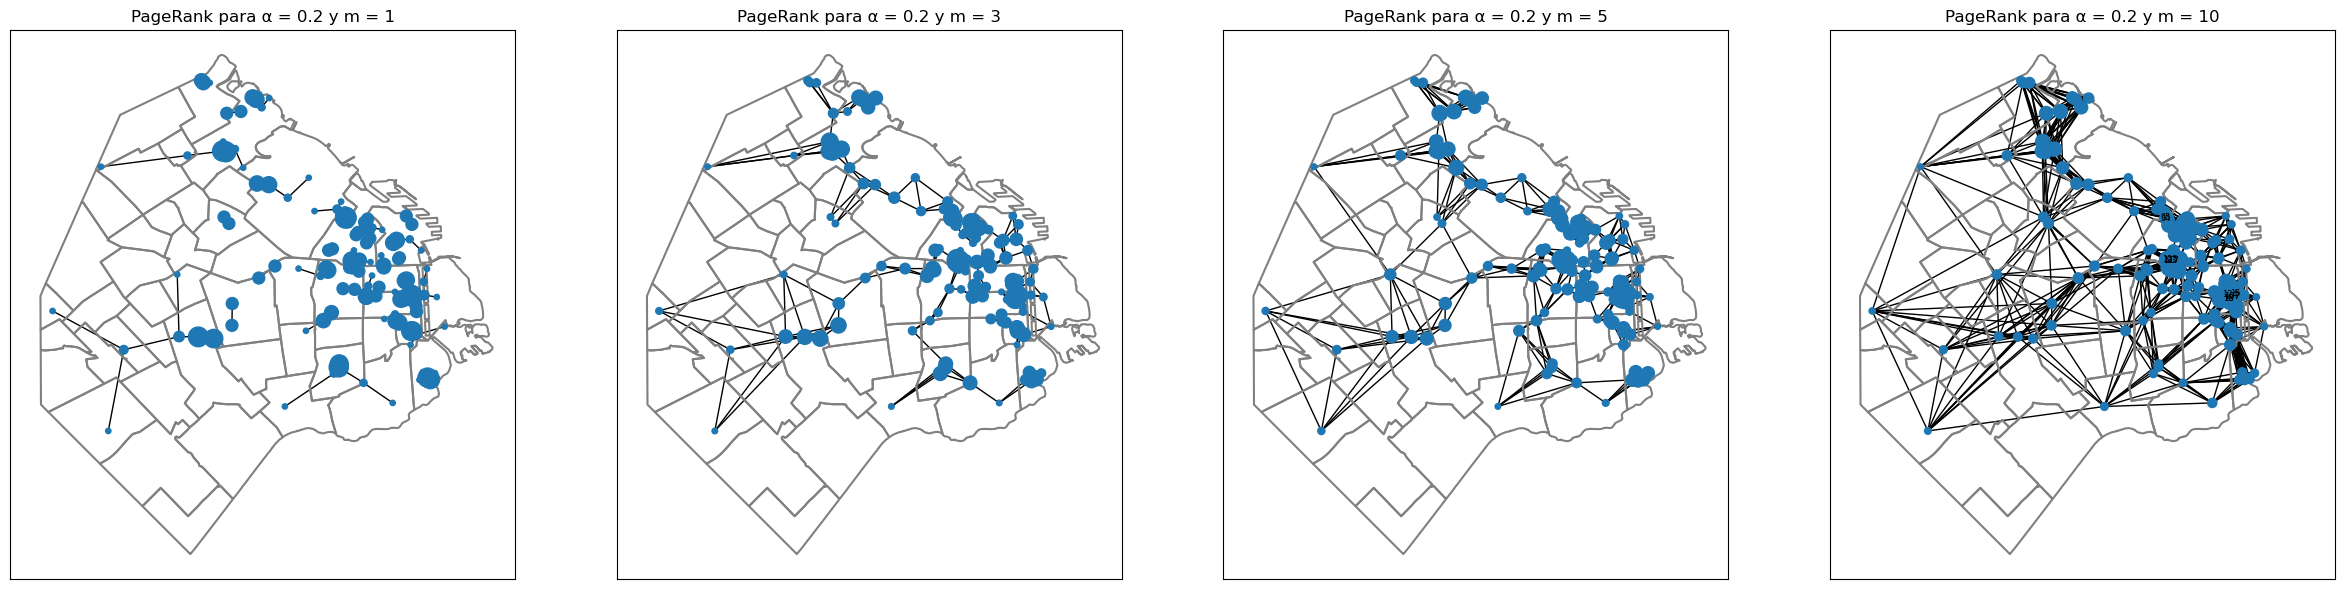

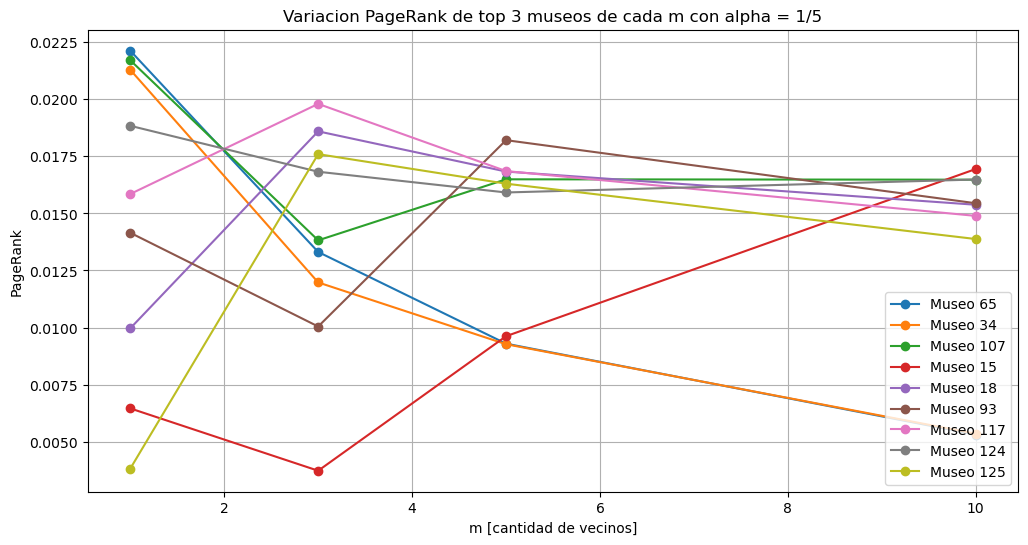

,m,Top 1,Top 2,Top 3
0,1,Museo 34,Museo 107,Museo 65
1,3,Museo 125,Museo 18,Museo 117
2,5,Museo 18,Museo 117,Museo 93
3,10,Museo 107,Museo 124,Museo 15


In [8]:
#Aca ploteamos con alpha fijo en 1/5 y m variando en distintos valores (crecientes)
cant_vecinos_cercanos = [m_1, m_3, m_5, m_10]
vectores_p_page_ranking = []
set_museos = set() #conjunto para no tener repetidos
data_top3 = []

# Iteramos la lista de cantidad de vecinos más cercanos (crecientes) y vamos resolviendo con factorización LU.
# Luego ordenamos vector p para obtener los 3 mayores, los cuales vamos a guardar en un conjunto (set) para que no haya
# repetidos a la hora de plotearlos, luego armamos los títulos para nuestro método
# (solamente seran tenidos en cuenta aquellos museos que alguna vez hayan estado en el top 3 para cualquier alpha)
# Se analizará el valor de PageRanking y su evolucion a medida que cambia m para los museos mencionados.

fig, axs = plt.subplots(1, len(cant_vecinos_cercanos), figsize=(30, 40))

for i in range(len(cant_vecinos_cercanos)):
    m_value = cant_vecinos_cercanos[i]
    M = matriz_M(alpha_1_5, m_value)
    L, U = elim_gaussiana(M)
    y = y_calculator(L, b)
    p = x_calculator(U, y)
    
    ploteador(p,m_value, axs[i])
    axs[i].set_title(f'PageRank para α = {alpha_1_5} y m = {m_value}')
    vectores_p_page_ranking.append(p)
    top3 = np.argsort(p)[-3:]  
    for l in range(3):
        set_museos.add(top3[l])
    data_top3.append({
        'm': m_value,
        'Top 1': f'Museo {top3[0]}',
        'Top 2': f'Museo {top3[1]}',
        'Top 3': f'Museo {top3[2]}'
    })
arguments_for_plot = [1,3,5,10]
label_m = 'm [cantidad de vecinos]'
title_m = 'Variacion PageRank de top 3 museos de cada m con alpha = 1/5'

plot_page_rank_usando_m_o_alpha(set_museos, vectores_p_page_ranking, label_m, title_m, cant_vecinos_cercanos)

df_top3_museos = pd.DataFrame(data_top3)
display(df_top3_museos)


Lo que podemos observar a partir de dejar fijo el parametros $\alpha$ = $\frac{1}{5}$ es:
* varía significativamente la selección de top 3 museos a medida que $m$ cambia.
* el valor de PageRank de los museos estudiados demostró una gran diferencia para cada valor de $m$.

Cuando $m$ es bajo podemos ver que los museos aledaños y que se apuntan mutuamente son los de mayor PageRank. Notemos que hay mucha diferencia entre los PageRanks de los distintos nodos viendo la disparidad de tamaño entre los mismos. Los mayores PageRanks se forman en los museos que se encuetran dentro de grupos donde los elementos están más cercanos unos de otros ya que la cantidad de vecinos es baja y $\alpha$ tiene un valor relativamente bajo, por lo que no hay tantas probabilidades de que el surfer se desvíe de los museos mas cercanos.

Cuando $m$ es alto vemos que los 3 mayores PageRanks están muy cercanos el uno del otro. Esto se debe a que se encuentran en el medio de grandes conjuntos de museos, los cuales ahora son mucho mas amplios porque pueden recibir influencia de museos más lejanos, esto da como resultado que los museos con mayor valor vayan cambiando radicalmente ya que no solamente se relacionan con los museos más cercanos sino que también con museos de grupos más dispersos en la periferia. También podemos observar que los valores de PageRank tienen una tendencia a permanecer igual cuando tienen un $\alpha$ bajo y varía $m$, lo que cambia son los museos con mayor valor.

En conclusión, si $m$ es bajo el pageRank se distribuye equitativamente entre los disntintos subgrupos definidos por cercanía, mientras que si $m$ es alto este valor se focaliza en museos ubicados en posiciones más centralizadas.


### Ejercicio C

> Para $m$ = 5, considerando los valores de $\alpha = \frac{6}{7}, \frac{4}{5}, \frac{2}{3}, \frac{1}{2}, \frac{1}{3}, \frac{1}{5}, \frac{1}{7}$.

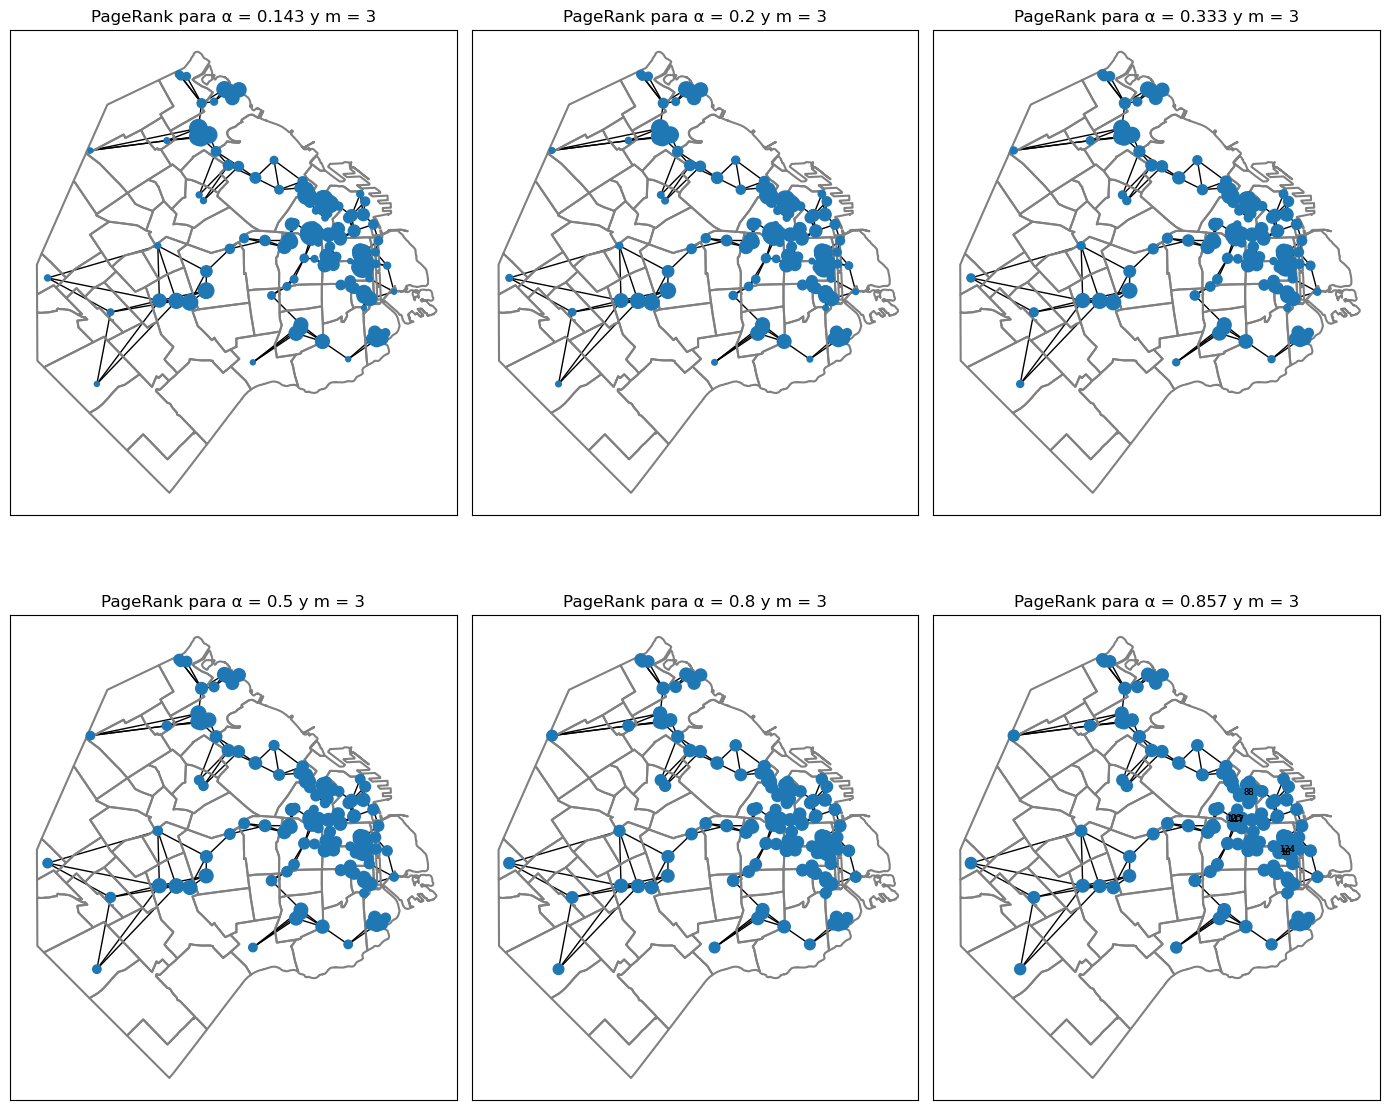

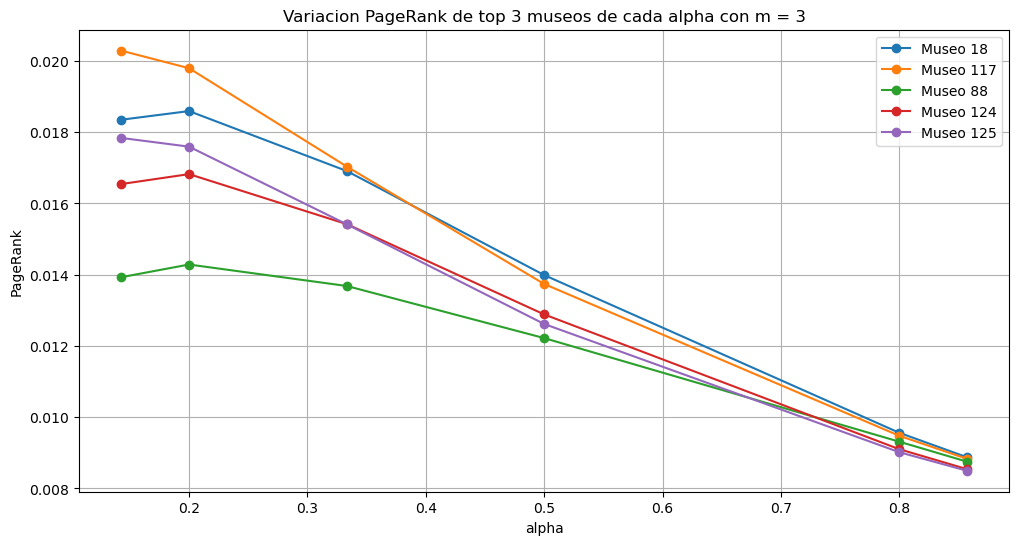

,α,Top 1,Top 2,Top 3
0,0.143,Museo 125,Museo 18,Museo 117
1,0.200,Museo 125,Museo 18,Museo 117
2,0.333,Museo 124,Museo 18,Museo 117
3,0.500,Museo 124,Museo 117,Museo 18
4,0.800,Museo 88,Museo 117,Museo 18
5,0.857,Museo 88,Museo 117,Museo 18


In [9]:
#Aca ploteamos con m fijo en 3 y alpha variando en distintos valores (crecientes)
alphas = [alpha_1_7, alpha_1_5, alpha_1_3,  alpha_1_2, alpha_4_5, alpha_6_7]
vectores_p_page_ranking = []
set_museos = set()
data_top3 = []

# Iteramos la lista de cantidad de vecinos más cercanos (crecientes) y vamos resolviendo con factorización LU.
# Luego ordenamos vector p para obtener los 3 mayores, los cuales vamos a guardar en un conjunto (set) para que no haya
# repetidos a la hora de plotearlos, luego armamos los títulos para nuestro método
# (solamente seran tenidos en cuenta aquellos museos que alguna vez hayan estado en el top 3 para cualquier alpha)
# Se analizará el valor de PageRanking y su evolucion a medida que cambia alpha para los museos mencionados.

fig, axs = plt.subplots(2, 3, figsize=(14, 20), tight_layout=False)
k = 0
for i in range(2):
    for j in range(3):
        alpha = alphas[k]
        k += 1 
        M = matriz_M(alpha, m_3)
        L, U = elim_gaussiana(M)
        y = y_calculator(L, b)
        p = x_calculator(U, y)
        ploteador(p, m_3, axs[i, j])
        axs[i, j].set_title(f'PageRank para α = {round(alpha, 3)} y m = {m_3}')
        vectores_p_page_ranking.append(p)
        top3 = np.argsort(p)[-3:]
        for l in range(3):
            set_museos.add(top3[l])
        data_top3.append({
            'α': round(alpha, 3),
            'Top 1': f'Museo {top3[0]}',
            'Top 2': f'Museo {top3[1]}',
            'Top 3': f'Museo {top3[2]}'
        })

#Aca ya obtenemos los vectores de rankings p para los respectivos valores alpha y m = 3.

label_a = 'alpha'
title_a = 'Variacion PageRank de top 3 museos de cada alpha con m = 3'

plot_page_rank_usando_m_o_alpha(set_museos, vectores_p_page_ranking, label_a, title_a, alphas)
df_top3_museos = pd.DataFrame(data_top3)
display(df_top3_museos)

Dejando fijo el parámetro $m$ = 3 y variando el valor de $\alpha$ podemos observar que se reducen los valores del PageRank a medida que $\alpha$ crece y $m$ permanece en un valor bajo.

A diferencia del análisis anterior donde se mantuvo fijo el valor de $\alpha$, la selección de top 3 de museos varió mucho menos en este nuevo estudio.

Cuando $\alpha$ tiene un valor bajo se puede observar en los mapas que los 3 museos con mayor PageRank tienen valores más grandes (mayor tamaño) y están juntos ya que se apuntan entre sí. Esto se debe a que la probabilidad de ir a un museo que no sea alguno de los 3 mas cercanos es baja por lo que el mayor PageRank se da en zonas donde se concentra una gran cantidad de museos. Esto también genera mucha más disparidad en el PageRank resultante de los museos, tenemos maximos y minimos muy amplios (podemos verlo en el tamaño de los nodos)

A medida que $\alpha$ crece aumenta la aleatoreidad del 'surfer' y por lo tanto descentraliza los valores de PageRank de los zonas donde se concentra una gran cantidad de museos y se distribuye mucho mas uniformemente. Podemos ver en el último mapa que los 3 museos con mayor PageRank estan separados entre si y los valores generales de pageRank se encuentras más balancedos.

## Punto 4:

>Supongan que cada persona realiza $r$ visitas antes de abandonar la red de museos. Si
el número total de visitas que recibió cada museo está dado por el vector $w$, tal que
$w_i$ tiene el número total de visitantes que se recibieron en el museo $i$, muestre que el
vector $v$, que tiene en su componente $v_i$ el número de personas que tuvo al museo $i$
como punto de entrada a la red, puede estimarse como:
>$$
v = B^{-1} \cdot w
$$


$w$ = Vector que contiene en cada componente una representación del número total de visitas que recibió cada museo.  
$v$ = Vector que conteine en cada componente una representación del número de visitas que recibió cada museo en el punto de partida.

$C$ es la matriz estocástica que contiene en la posición $C_{ji}$ la probabilidad de ir de un museo $i$ a un museo $j$.

Al realizar producto matricial con la matriz $C$ y el vector $v$, obtengo un vector $v_1$.  
Si se hace la misma aplicación sobre $v_1$ obtengo un $v_2$ con la información de los visitantes en una segunda iteración.  
Este procedimiento se puede repetir $k$ veces de modo que:

$$
v_k = C^k \cdot v
$$

(recordemos la propiedad de asociatividad $C(C \cdot v) = (C \cdot C) \cdot v$

Queda definido entonces, la matriz $C^k$ que contiene en la posición $C_{ji}$ la probabilidad de ir de un museo $i$ a $j$ en $k$ pasos. Esta matriz sigue siendo estocástica.

$w$, al representar el número total de visitas en $r$ iteraciones, se puede describir como la sumatoria de todos los $v$ (desde $0$ a $r-1$).  
Luego:

$$
w = \sum_{k=0}^{r-1} v_k
$$

Sea:

$$
B = \sum_{k=0}^{r-1} C^k
$$

la matriz que, al transformar un vector $v$ con el número inicial de visitantes en cada elemento, obtengo el número total de visitas en cada múseo en $r$ pasos.

Demostremos que:

$$
v = B^{-1} \cdot w
$$

$$
v = B^{-1} \cdot w \Leftrightarrow B \cdot v = w \Leftrightarrow \left( \sum_{k=0}^{r-1} C^k \right) \cdot v = \sum_{k=0}^{r-1} v_k
$$

pero $v_k = C^k \cdot v$, entonces:

$$
\sum_{k=0}^{r-1} C^k \cdot v = C^0 \cdot v + C^1 \cdot v + C^2 \cdot v + \dots + C^{r-1} \cdot v = (C^0 + C^1 + C^2 + \dots + C^{r-1}) \cdot v = \left( \sum_{k=0}^{r-1} C^k \right) \cdot v
$$


Finalmente podemos concluir que:

$$
v = B^{-1} \cdot w \quad 
$$


## Punto 5:

Aca vamos a describir que pasos vamos a llevar a cabo en cada item del ejercicio, comenzando con el item a basicamente calculamos:
$$
C_{ji} = P(i \rightarrow j) = \frac{f(d_{ij})}{\sum_{\substack{k=1, k\ne i}}^{N} f(d_{ik})}
$$
Luego para item b, implementamos la siguiente formula para calcular B ahora que tenemos C a partir del item anterior
$$
B = \sum_{k=0}^{r-1} C^k
$$
y finalmente para el item c, factorizamos B para hallar:
$$
v = B^{-1} \cdot w \quad 
$$
Por lo que el procedimiento implementado para resolverlo fue el siguiente:
$$
B \cdot v = w
$$
$$
LU \cdot v = w
$$
$$
L \cdot y = w
$$
Resolvemos con el L triangulado para obtener w, y resolvemos:
$$
U \cdot v = y
$$
Resolvemos el sistema con U triangulado y finalmente obtenemos v, al cual si le calculamos la norma obtenemos lo que estabamos buscando, que era la cantidad de visitantes que entraron en la red


In [10]:
#Seteamos variables globales que vamos a necesitar

vector_w = pd.read_csv('./visitas.txt', sep='\t', header=None).squeeze("columns").values
r=3


#Ejercicio a)

# En Calcula_matriz_C_continua(D) lo que hacemos es recorrer D (matriz de distancias de museos) y calculamos F que es la matriz 1/D, luego 
# vamos calculando la sumatoria de la fila de F hasta que finalizemos de recorrerla y una vez que finalizamos calculamos k inversa, que al ser
# k la matriz con unicamente la sumatoria de f en su diagonal entonces su inversa la podemos calcular como 1/sumatoria_fila, finalmente
# llegamos a C haciendo la muplicacion matricial K_inv @ F

def calcula_matriz_C_continua(D):
    N = D.shape[0]
    sumatoria_fila = 0
    F = np.zeros((N,N))
    K_inv = np.zeros((N,N))
    
    for fila in range(N):
        sumatoria_fila = 0
        for columna in range(N):
            if fila!=columna:
                F[fila][columna] = 1/D[fila][columna]
                sumatoria_fila += F[fila][columna]
        for columna in range(N):
            if fila==columna:
                K_inv[fila][columna] = 1/sumatoria_fila
    return F @ K_inv

# Ejercicio b)

# Aca calculamos la matriz B como la sumatoria de las potencias de C^k con k yendo de 0 hasta r-1, 

def calcula_B(C, cantidad_de_visitas):
    B = np.eye(C.shape[0])  # C^0
    C_k = np.eye(C.shape[0])
    for k in range(cantidad_de_visitas-1):
        C_k = C_k @ C
        B += C_k
    return B

# Ejercicio c)

# Aca finalmente resolvemos directamente como vinimos haciendo anteriormente en el tp, con factorizacion LU en vez de invertir B, con su debida 
# justificacion arriba, las funciones son las definidas previamente tambien mas arriba en el trabajo. Luego resolvemos y obtenemos calculando
# norma 1 de el vector solucion v para obtener la cantidad de visitas

C = calcula_matriz_C_continua(D)
B = calcula_B(C,r)
L, U = elim_gaussiana(B)
y = y_calculator(L, vector_w)
v = x_calculator(U, y)

cantidad_visitas = np.linalg.norm(v, 1)
print(cantidad_visitas)

136901.2072449656


## Punto 6:

Sea $w$ un vector que representa las visitas totales de cada museo, estimamos $v$ (visitas inciales en cada museo).

Dado que $w$ podría tener un error de hasta el 5%, queremos estimar el error que se podría obtener al realizar la transformación B sobre el vector $w$, tal que

$$
v = B^{-1} \cdot w
$$

Para ello, queremos calcular el número de condición de $B$ para poder estimar una cota superior sobre el error de $v$ tal que

$$
\frac{\|v\|_1 - \|\tilde{v}\|_1}{\|v\|_1} \leq cond_1(B) \cdot \frac{\|w\|_1 - \|\tilde{w}\|_1}{\|w\|_1}
$$

In [11]:
def norma1(M):
    res = np.sum(np.abs(M), axis=0).max()
    return res


# Calculamos la inversa de B con su factorizacion LU para obtener el numero de condicion
def inversa(L, U):
    # Calculamos numero de la condición y con él resolvemos
    n = L.shape[0]
    identidad = np.eye(n)
    
    columna_inversa_B = []
    for i in range(n):
        columna_i = identidad[i]
        y = y_calculator(L, columna_i)
        x = x_calculator(U, y)
        columna_inversa_B.append(x)
    return np.column_stack(columna_inversa_B)

inversa_B_2 = inversa(L, U)

# Calculamos la norma de B y B^(-1) para multiplicarlas y obtener cond(B)
norma_1_B = norma1(B)
norma_1_inv_B = norma1(inversa_B_2)

# Calculamos el numero de condicion
cond_B = norma_1_B * norma_1_inv_B

# Multiplimos el numero de condicion por 0.05 para obtener una cota superior del error de v
error = 0.05
error_v = cond_B * error
print(error_v)

0.2526295472386763


# PARTE 2 

## Punto 1:

### Ejercicio A.
> Muestren que el vector de unos $1_v$ es autovector de las matrices $R$ y $L$. ¿Qué
autovalor tiene? ¿Y qué agrupacién de la red representa?


$1_v$ es autovector de $L \Rightarrow$ Existe $\lambda \in \mathbb{R}$ tal que $L \cdot 1_v = \lambda \cdot 1_v$.

$$L = K - A \Rightarrow (K - A) \cdot 1_v = K \cdot 1_v - A \cdot 1_v$$

Sea el $k$, aquel vector con $k_i$ , la cantidad de conexiones de $i$. 
Tal que $k_i = \sum_{i=1}^{n} A_{ij}$


$$
K = \begin{pmatrix}
k_1 & 0 & \cdots & 0 \\
0 & k_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & k_n
\end{pmatrix}.
$$

Luego, $K \cdot 1_v = k$.

Por otro lado,

$$A \cdot 1_v  =  (\sum_{j=1}^{n} A_{1j}, \sum_{j=1}^{n} A_{2j}, \dots, \sum_{j=1}^{n} A_{nj})  =  (k_1, ... ,k_n)  =  k$$

Entonces, tengo que 

$$K \cdot 1_v - A \cdot 1_v = k - k = 0 = \lambda \cdot 1_v.$$

Luego, si $\lambda \cdot 1_v = 0 \Rightarrow \lambda = 0$.


Veamos que:

$\lambda = \frac{1}{4} \cdot s^t \cdot L \cdot s$  siendo $s$ el vector tal que $s_i = 1$ si $i$ pertenece al grupo $1$ y $s_i = -1$ si $i$ pertenece al grupo $2$.

Y $\lambda$ representa la cantidad de cortes.

Tomemos a $s = 1_v$ 

$$\Rightarrow \lambda = \frac{1}{4} \cdot 1_v^t \cdot L \cdot 1_v = \frac{1}{4} \cdot (0 \cdot 1_v) = \frac{1}{4} \cdot 0 = 0$$

Entonces $\lambda = 0$.

Esto representa el caso en el que todos los elementos pertenecen al mismo grupo, por lo que no existe ningun corte.


$1_v$ es autovector de $L \Rightarrow$ Existe $\lambda \in \mathbb{R}$ tal que $L \cdot 1_v = \lambda \cdot 1_v$.

$$R = A - P \Rightarrow (A - P) \cdot 1_v = A \cdot 1_v - P \cdot 1_v.$$

llamemos $P \cdot 1_v = h$.

$$h_i = \sum_{j=1}^{n} \frac{k_i \cdot k_j}{2E} = \frac{ki}{2E} \cdot \sum_{j=1}^{n} k_j.$$


Pero 

$$2E = \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij} = \sum_{i=1}^{n} k_j.$$

Luego, 

$$\frac{ki}{2E} \cdot \sum_{j=1}^{n} k_j = \frac{ki}{\cancel{2E}} \cdot \cancel{2E} = k_i \Rightarrow h_i = k_i \Rightarrow h = k \Rightarrow P \cdot 1_v = k.$$


Entonces, como $A \cdot 1_v = k$  y 

$$P \cdot 1_v = k \Rightarrow  A \cdot 1_v - P \cdot 1_v = k - k = 0 = \lambda \cdot 1_v.$$

Luego, si $\lambda \cdot 1_v = 0 \Rightarrow \lambda = 0$.


Veamos que,

$$Q = \frac{1}{4E} \cdot 1_v^t \cdot R \cdot 1_v = \frac{1}{4E} \cdot 1_v^t \cdot 0 = 0.$$

Esto representa que para $s = 1_v$ (todos los elementos del mismo grupo), la modularidad es $0$. 

Esto quiere decir, que hay las mismas conexiones entre ellos que las que esperamos.

### Ejercicio B.

> Muestren que si L (R) tienen dos autovectores v1 y v2 asociados a autovalores
$\lambda_1 \neq \lambda_2$, entonces $v_1^t * v_2 = 0.$

Veamos que $L$ y $R$ son matrices simétricas.
Tomo una matriz $M$ genérica, trato de mostrar que si $M$ es simétrica con 2 autovalores $\lambda_1$ y $\lambda_2$. Entonces, sus autovectores asociados ($v_1$ y $v_2$, respectivamente) son ortogonales entre sí, esto significa que $v_1^t \cdot v_2 = 0$.

Sea $v_2$ autovector de $M$ 

$$\Rightarrow M \cdot v_2 = \lambda_2 \cdot v_2$$ 

$$\Leftrightarrow v_1^t \cdot (M \cdot v_2) = v_1^t \cdot (\lambda_2 \cdot v_2)$$ 

$$\Leftrightarrow v_1^t \cdot M \cdot v_2 = \lambda_2 \cdot v_1^t v_2$$

Sea $v_1$ autovector de $M$ 

$$\Rightarrow M \cdot v_1 = \lambda_1 \cdot v_1 \Leftrightarrow v_2^t \cdot (M \cdot v_1) = v_2^t \cdot (\lambda_1 \cdot v_1)$$

$$\Leftrightarrow (v_2^t \cdot M \cdot v_1)^t = (v_2^t \cdot \lambda_1 \cdot v_1)^t$$

$$\Leftrightarrow v_1^t \cdot M^t \cdot (v_2^t)^t = v_1^t \cdot \lambda_1 \cdot (v_2^t)^t$$

$$\Leftrightarrow v_1^t \cdot M^t \cdot v_2 = v_1^t \cdot \lambda_1 \cdot v_2$$

pero $M^t = M$, entonces:

$$v_1^t \cdot M^t \cdot v_2 = v_1^t \cdot \lambda_1 \cdot v_2$$

$$\Leftrightarrow v_1^t \cdot M \cdot v_2 = \lambda_1 \cdot v_1^t \cdot v_2$$

En resumen:

$v_2$ autovector de $M \Rightarrow v_1^t \cdot M \cdot v_2 = \lambda_2 \cdot v_1^t \cdot v_2$

$v_1$ autovector de $M \Rightarrow v_1^t \cdot M \cdot v_2 = \lambda_1 \cdot v_1^t \cdot v_2$

Igualando ambas ecuaciones:
$\lambda_2 \cdot (v_1^t \cdot v_2) = \lambda_1 \cdot (v_1^t \cdot v_2)$

Esto es posible si y solo si:

$\lambda_1 = \lambda_2$ ó $(v_1^t \cdot v_2) = 0.$


Entonces, queda demostrado que, si $\lambda_1  \neq  \lambda_2 \Rightarrow v_1^t \cdot v_2 = 0$. Para toda matríz M simétrica.

Como $R$ y $L$ son matrices simétricas, queda mostrado que dos autovectores $v_1$ y $v_2$ asociados a autovalores $\lambda_1 \neq \lambda_2$, entonces $v_1^t \cdot v_2 = 0$.


### Ejercicio C.
 >Muestren si v es un autovector de autovalor λ ̸= 0 de R o L, entonces sumatoria desde i = 0 hasta n de v_i = 0

Sabemos que:

* por punto a: $1_v$ es autovector de las matrices $R$ y $L$ con autovalor $0$ para ambos.

* por punto b: Tanto para $L$ como para $R$, se cumple que, para autovalores $\lambda_1 \neq \lambda_2 \Rightarrow$ autovectores asociados $v_1$, $v_2$: $v_1^t \cdot v_2 = 0$.

Tomando $v_1 = 1_v$ y $v_2$ autovector con autovalor $\neq 0$:

$$v_1^t \cdot v_2 = 0 \Leftrightarrow 1_v^t \cdot v_2 = 0$$ 

$$\Leftrightarrow 1 \cdot (v_2)_1 + 1 \cdot (v_2)_2 + ... + 1 \cdot (v_2)_n = 0$$

$$\Leftrightarrow \sum_{i=1}^{n} (v_2)_i = 0.$$

Luego, queda demostrado que para cualquier autovalor distinto de $0$, la suma de los elementos de su autovector asociado equivale a $0$.


## Punto 2:

### Ejercicio A.
> Shifting de autovalores: Muestre que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$, y que el autovector asociado a $\gamma_i$ es $v_i$.
Concluya que si $\mu + \lambda_i \ne 0 \ \forall i$, entonces $M + \mu I$ es inversible.


Para demostrar esto vamos a comenzar viendo que:
$$
(M + \mu I) \cdot v_i = (\lambda_i + \mu) \cdot v_i \equiv  
$$
$$
(M + \mu I) \cdot v_i - (\lambda_i + \mu) \cdot v_i = 0 \equiv
$$
$$
(M + \mu I - \lambda_i I - \mu I) \cdot v_i = 0 \equiv  
$$
$$
(M - \lambda_i I )\cdot v_i = 0 \equiv  
$$
$$
M \cdot v_i = \lambda_i \cdot v_i  
$$
Lo que podemos observar es que si $\lambda_i$ es autovalor de $M$, entonces $(\lambda_i + \mu)$ es autovalor de $(M + \mu I)$, también podemos ver que efectivamente $v_i$ no cambia por lo que el autovector asociado al autovalor no cambia. 

Recordemos la propiedad de que si una matríz no tiene ningún autovalor igual a 0, entonces es inversible.
Para demostrar esto tomemos una matríz genérica $A$.

Los autovalores asociados a $A$ son aquellos $\lambda$ que cumplen lo siguiente:
$$
det(A - \lambda I) = 0
$$
pero si 
$$
\lambda = 0
$$
Entonces
$$
det(A - 0I) = det(A) = 0
$$
Luego $A$ NO ES INVERSIBLE.

Volviendo a nuestro análisis, como $\mu + \lambda_i = \gamma_i$ es autovalor de $M + \mu I$, por la propiedad anteriormente demostrada, podemos concluir que $M + \mu I$ es inversible si y solo si $\mu + \lambda_i \ne 0  \ \forall i$


### Ejercicio B.

> Método de la potencia inverso: Considerando $\mu$ > 0, muestren que $L + \mu I$ es
inversible, con L el laplaciano definido en la ecuación 2. Muestren que aplicar el
método de la potencia a $(L + \mu I)^{-1}$
converge a su autovector de autovalor más
chico si se parte de una semilla adecuada. Indique, en el caso de que hay sólo un
autovector con dicho autovalor, cuál es dicho autovector y cuánto vale su autovalor

Como sabemos por el punto 1, $\lambda = 0$ es un autovalor de la matriz Laplaciana $L$, y su autovector asociado es el vector constante de unos $$\mathbf{1} = (1, 1, \ldots, 1)$$ 
Ademas se nos dice que $L$ es una matriz simétrica y semidefinida positiva, esto quiere decir que todos sus autovalores $\lambda_i$ son Reales y $\geq 0$.

Al considerar la matriz $(L + \mu I)$, con $(\mu > 0)$, los nuevos autovalores son:
$$
\lambda_i + \mu > 0 \quad \forall i
$$
Esto vale por lo demostrado en el item a). Por lo que todos los autovalores de la matriz son diferentes de 0 y por lo tanto es inversible.

Ahora consideramos la matriz inversa $(L + \mu I)^{-1}$. Sabemos que  $L$ y $L + \mu I$ comparten los mismos autovectores, veamos que comparten los mismos autovectores con su inversa:
$$
L \cdot v_i = \lambda_i \cdot v_i \equiv
$$
$$
(L + \mu I) \cdot v_i = (\lambda_i + \mu) \cdot v_i
$$

Ahora, como $(L + \mu I)$ es inversible por lo demostrado anteriormente podemos aplicar la inversa de ambos lados:

$$
(L + \mu I)^{-1} (L + \mu I) \cdot v_i = (L + \mu I)^{-1} (\lambda_i + \mu) \cdot v_i \equiv
$$
$$
I \cdot v_i = (L + \mu I)^{-1} (\lambda_i + \mu) \cdot v_i \equiv
$$
$$
v_i = (\lambda_i + \mu)(L + \mu I)^{-1} \cdot v_i \equiv
$$
$$
\frac{1}{\lambda_i + \mu} \cdot v_i = (L + \mu I)^{-1} \cdot v_i \equiv
$$
$$
(L + \mu I)^{-1} \cdot v_i = \frac{1}{\lambda_i + \mu} \cdot v_i 
$$
Por lo que $v_i$ es el mismo autovector para $(L + \mu I)^{-1}$ y su autovalor asociado resulta siendo: 
$\frac{1}{\lambda_i + \mu}$ $\forall \lambda_i$ autovalor de $L$

Como $\lambda_i + \mu > 0$, todos los autovalores $\frac{1}{\lambda_i + \mu}$ son positivos y están bien definidos.

Ahora bien, como $L$ es semidefinida positiva entonces todos sus autovalores son $\geq 0$, y sabemos que 0 es autovalor de L, por lo que podemos asegurar que se cumple lo siguiente para la matriz $(L + \mu I)^{-1}$:
$$
\max_i \left\{ \frac{1}{\lambda_i + \mu} \right\} = \frac{1}{\mu}
$$

A partir de esto sabemos que si aplicamos el metodo de la potencia, el cual dice que si A es diagonalizable y su autovalor de mayor módulo es único, entonces este converge al autovector asociado a ese autovalor a partir de un a semilla inicial adecuada, por lo que solamente nos falta demostrar que $(L + \mu I)^{-1}$ es diagonalizable:

$L$ es simétrica, y por lo tanto $(L + \mu I)$ lo es, entonces la suma es diagonalizable en una base ortonormal, esto se puede desprender a partir del teorema espectral, por lo que esto significa que existe matriz ortogonal $Q$ y una matriz diagonal $D$ tal que
$$
(L + \mu I) =  Q(D + \mu I)Q^T.
$$

Como $D$ es diagonal y $\mu I$ tambien, entonces la suma de estos es diagonal y va a contener los autovalores de forma $(\lambda + \mu)$ que efectivamente son los autovalores de $(L + \mu I)$. 

Ahora sabemos que existe la inversa de esta matriz por lo que D va a estar compuesta de los autovalores $\frac{1}{\lambda_i + \mu}$ en su diagonal. 
Ahora, por propiedad sabemos que $(QDQ^T)^{-1} = QD^{-1}Q^T$ (dado que $Q^T = Q^{-1}$), por lo que finalmente obtenemos:
$$
(L + \mu I)^{-1} = Q(D + \mu I)^{-1}Q^T
$$
Llegamos a que $(L + \mu I)^{-1}$ es diagonalizable con autovalor mayor de valor unico, entonces a partir de un $x_0$ adecuado vamos a obtener el autovector asociado al mayor autovalor de la matriz, que en este caso va a ser 

El autovalor obtenido va a ser el autovalor mas chico de la matriz $(L + \mu I)$, es decir, convergera a $$\mathbf{1} = (1, 1, \ldots, 1)$$ con autovalor $\frac{1}{\mu}$.
 

### Ejercicio C.

> Deflación de Hotelling: Suponiendo que $M$ es simétrica (y por lo tanto admite una base ortogonal de autovectores), muestre que la matriz
>$$
>\tilde{M} = M - \frac{\lambda_1 v_1 v_1^t}{v_1^t v_1}
>$$
> tiene los mismos autovectores que $M$, pero el autovalor asociado a $v_1$ es igual a cero.



Para demostrar esto vamos a comenzar con que como M es simetrica entonces admite una base ortogonal de autovectores, este dato nos va a servir para luego, ahora demostremos que para todo $v_k$ con $k \neq 1$  vale que la matriz $M - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t}}{v_1^{t} \cdot v_1}$ tiene los mismos autovectores que la matriz $M$:
$$
(M - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t}}{v_1^{t} \cdot v_1}) \cdot v_k = (\lambda_k - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t}}{v_1^{t} \cdot v_1}) \cdot v_k
$$
$$
(M \cdot v_k - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t} \cdot v_k}{v_1^{t} \cdot v_1}) = (\lambda_k \cdot v_k - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t} \cdot v_k}{v_1^{t} \cdot v_1}) 
$$
Ahora, como tenemos que M es simetrica y que por lo tanto admite una base ortogonal de autovectores, esto significa que para todo $v_i, v_j$ con $i \neq j$ y $\lambda_i \neq \lambda_j$, que $v_i \cdot v_j$ = 0 (son ortogonales entre si)
Entonces como por hipotesis $v_k$ es autovector de de M y $k \neq 1$ entonces $v_1^{t} \cdot v_k = 0$
Por lo que queda
$$
(M \cdot v_k - \lambda_1 \cdot \frac{v_1 \cdot 0}{v_1^{t} \cdot v_1}) = (\lambda_k \cdot v_k - \lambda_1 \cdot \frac{v_1 \cdot 0}{v_1^{t} \cdot v_1})
$$
$$
(M \cdot v_k - \lambda_1 \cdot 0 )= (\lambda_k \cdot v_k - \lambda_1 \cdot 0)
$$
$$
M \cdot v_k = \lambda_k \cdot v_k
$$
Y esta es la definicion de autovalores y autovectores de M, por lo que $\forall v_k / k \neq 1$ se tiene que son los mismo autovectores que M. 
Ahora, veamos porque esto no vale para $v_1$, lo que vamos a hacer para demostrarlo es que para $v_1$ efectivamente nos queda igualado a 0:

$$
(M - \lambda_1 \cdot \frac{v_1 \cdot v_1^t}{v_1^{t} \cdot v_1}) \cdot v_1 = 0
$$
$$
M \cdot v_1 - \lambda_1 \cdot \frac{v_1 \cdot v_1^t}{v_1^{t} \cdot v_1} = 0
$$
$$
\lambda_1 \cdot v_1 - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t} \cdot v_1}{v_1^{t} \cdot v_1} = 0
$$
Nos queda $v_1^t \cdot v_1$ en ambas partes de la fraccion, esto es equivalente $\|v\|^2$, ya que estamos multiplicando cada coordenada de v por si misma. por lo que obtenemos:
$$
\lambda_1 \cdot v_1 - \lambda_1 \cdot \frac{v_1 \cdot \|v\|^2}{\|v\|^2} = 0
$$
$$
\lambda_1 \cdot v_1 - \lambda_1 \cdot v_1 = 0
$$
Lo cual es verdadero y por lo tanto llegamos a que $v_1$ es autovector de la matriz pero su autovalor asociado es el 0 para $M - \lambda_1 \cdot \frac{v_1 \cdot v_1^{t}}{v_1^{t} \cdot v_1}$. Quedando demostrado que esta matriz comparte los mismos autovectores que $M$ pero el autovalor asociado a $v_1$ es 0.


## Punto 3:

### Ejercicio A.

>### *i*.
>*calcula_L($A$)* y *calcula_R($A$)* que reciban la matriz de adyacencia $A$ y retornen las matrices $L$ y $R$ respectivamente.

In [ ]:
# Matriz A de ejemplo
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

## helpers

def vector_1(n):
  return np.zeros((n, 1)) + 1

def calcula_K(A):
  n = A.shape[0]
  K = np.zeros((n, n))
  for i in range(n):
    K[i][i] = np.sum(A[i])
  return K

def calcula_vector_k(A):
  return calcula_K(A) @ vector_1(A.shape[0]);

def cant_conexiones(A):
  return A.sum() / 2

def calcula_P(A):
  k = calcula_vector_k(A)
  P = k * k.T / (2*cant_conexiones(A))
  return P

In [13]:
def calcula_L(A):
  return calcula_K(A) - A


def calcula_R(A):
    return A - calcula_P(A)

>### *ii.*
> *calcula_lambda($L$,$v$)* y *calcula_Q($R$,$v$)* que reciban las matrices $L$ y $R$, y
un autovector $v$, y retornen el corte $Λ$ y la modularidad $Q$ asociados a $v$.
Calculen con ellas el corte y la modularidad de las particiones esperadas en la
red de ejemplo.

In [14]:
def calcula_lambda(L,v):
    s = np.sign(v)
    return (1/4)*((s.T @ L) @ s)

def calcula_Q(R,v):
    s = np.sign(v)
    return (s.T @ R) @ s

v_ejemplo = np.array([1,1,1,1,-1,-1,-1,-1])
E = np.sum(A_ejemplo)/2

print("Corte:")
print(calcula_lambda(calcula_L(A_ejemplo), v_ejemplo))
print("Modularidad:")
print(calcula_Q(calcula_R(A_ejemplo), v_ejemplo)/(4*E))


Corte:
2.0
Modularidad:
0.35714285714285715


### Ejercicio B.

>### *i.*
> Una función *metpot1($M$)* que reciba una matriz $M$ y use el método de la
potencia para retornar el autovalor de mayor módulo y su correspondiente
autovector

In [15]:
np.random.seed(100)

def metpot1(A, tol=1e-8, maxrep=np.inf):
    v = np.random.uniform(low = -1.0, high = 1.0, size=len(A[0]))
    v = v / np.linalg.norm(v) #normalizo
    v1 = A @ v
    v1 = v1 / np.linalg.norm(v1)
    l = (v.T @ A @ v) / (v.T @ v)
    l1 = (v1.T @ A @ v1) / (v1.T @ v1)
    nrep = 0
    while  np.abs(l1 - l) / np.abs(l) > tol and nrep < maxrep:
        v = v1
        l = l1
        v1 = A @ v
        v1 = v1 / np.linalg.norm(v1)
        l1 = (v1.T @ A @ v1) / (v1.T @ v1)
        nrep += 1
    l = l1 
    return v1, l


> ### *ii.*
>Una función *deflaciona($M$)* que reciba una matriz $M$, calcule su primer autovector y autovalor, y calcule su versión deflacionada.

In [16]:
def deflaciona(A,tol=1e-8,maxrep=np.inf):
    # Recibe la matriz A, una tolerancia para el método de la potencia, y un número máximo de repeticiones
    v1,l1 = metpot1(A,tol,maxrep) # Buscamos primer autovector con método de la potencia
    deflA = A - l1 * np.outer(v1, v1) # Sugerencia, usar la funcion outer de numpy
    return deflA

> ### *iii.*
> Una función *metpotI($M$,$\mu$)* que reciba una matriz $M$ y un coeficiente $\mu$ y calcule el autovalor más chico de $M + \mu$ junto a su autovector asociado,
usando el método de la potencia inversa.

In [17]:


def metpot_inv(A, tol=1e-8, maxrep=np.inf):
  L, U = elim_gaussiana(A)
  A_inv = inversa(L, U)
  vect, val = metpot1(A_inv, tol=tol, maxrep=maxrep)
  return vect, 1/val

def metpotI(A, mu, tol=1e-8, maxrep=np.inf):
    # Retorna el primer autovalor de la inversa de A + mu * I, junto a su autovector y si el método convergió.
    shift = A + (mu * np.eye(A.shape[0]))
    return metpot_inv(shift, tol=tol, maxrep=maxrep)

> ### *iv.*
> Una función *metpotI2($M$,$\mu$)* que reciba una matriz $M$ y un coeficiente $\mu$ y calcule el segundo autovalor más chico, con su autovector asociado, de la
matriz $M + \mu I$, y bajo la suposición de que todos los autovectores de M son
no-negativos, y sólo uno de ellos es igual a cero.

In [18]:
def metpotI2(A, mu=10e-4, tol=1e-8, maxrep=np.inf):
    ID = np.eye(A.shape[0], A.shape[0])
    L, U = elim_gaussiana(A + (mu*ID))
    A_inv = inversa(L, U)
    A_def = deflaciona(A_inv,tol=1e-8,maxrep=np.inf)
    vect, val = metpot1(A_def, tol=tol, maxrep=maxrep)
    return vect, ((1/val) - mu)

In [31]:
L_ejemplo = calcula_L(A_ejemplo)

vect_L_ejemplo, val_L_ejemplo = metpotI2(L_ejemplo, 10e-4)
print("autovector asociado al segundo autovalor mas chico de la matriz L:")
print(vect_L_ejemplo)
print("Su s asociado:")
print(np.sign(vect_L_ejemplo))


R_ejemplo = calcula_R(A_ejemplo)
vect_R_ejemplo, val_R_ejemplo = metpot1(R_ejemplo)
print("Autovector asociado al mayor autovalor de R:")
print(vect_R_ejemplo)
print("Su s asociado:")
print(np.sign(vect_R_ejemplo))


autovector asociado al segundo autovalor mas chico de la matriz L:
[-0.05320797 -0.05320796  0.07908155  0.07681481  0.46241727  0.4547442
  0.55998649  0.49797242]
Su s asociado:
[-1. -1.  1.  1.  1.  1.  1.  1.]
Autovector asociado al mayor autovalor de R:
[ 0.39410272  0.39410272  0.30774731  0.30766489 -0.30766489 -0.30774731
 -0.39410272 -0.39410272]
Su s asociado:
[ 1.  1.  1.  1. -1. -1. -1. -1.]


La partición esperada es la que separa por un lado a los nodos $1, 2, 3$ y $4$, y por otro a los nodos $5, 6, 7$ y $8$. Esta es igual a la que nos da el $s$ asociado al autovector del segundo menor autovalor de $R$ 


### Ejercicio C.

> ### *i.*
>*laplaciano_iterativo($A$,niveles)* que reciba la matriz de adyacencia $A$ y
el número de niveles que se debe alcanzar realizando particiones iterativamente (para *niveles* = $k$ se obtienen $2^k$ particiones). La función debe calcular el
laplaciano $L$, y recursivamente partir la red hasta llegar a n niveles de partición. El resultado debe ser una lista de listas, donde cada sub-lista contiene
los indices de los nodos correspondientes a una misma comunidad.


In [20]:
def laplaciano_iterativo(A,niveles,nombres_s=None):
    # Recibe una matriz A, una cantidad de niveles sobre los que hacer cortes, y los nombres de los nodos
    # Retorna una lista con conjuntos de nodos representando las comunidades.
    # La función debe, recursivamente, ir realizando cortes y reduciendo en 1 el número de niveles hasta llegar a 0 y retornar.
    if nombres_s is None: # Si no se proveyeron nombres, los asignamos poniendo del 0 al N-1
        nombres_s = range(A.shape[0])
    if A.shape[0] == 1 or niveles == 0: # Si llegamos al último paso, retornamos los nombres en una lista
        return([nombres_s])
    else: # Sino:
        mu_identidad = np.eye(A.shape[0])*2
        L = calcula_L(A) + mu_identidad # Recalculamos el L

        v,l =  metpotI2(L)# Encontramos el segundo autovector de L
        # Recortamos A en dos partes, la que está asociada a el signo positivo de v y la que está asociada al negativo
        Ap = A[v >= 0][:, v >= 0] # Asociado al signo positivo
        Am = A[v < 0][:, v < 0] # Asociado al signo negativo
        return(
                laplaciano_iterativo(Ap,niveles-1,
                                     nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi>0]) +
                laplaciano_iterativo(Am,niveles-1,
                                     nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi<0])
                )

> ### *ii.*
> *modularidad_iterativo($A$)* que reciba la matriz de adyacencia $A$ y compute
la matriz de modularidad $R$. Luego debe realizar iterativamente particiones en
las comunidades del grafo en mitades. El algoritmo debe detenerse cuando las
siguientes divisiones no aumentan la modularidad total

In [21]:
def modularidad_iterativo(A=None,R=None,nombres_s=None):
    # Recibe una matriz A, una matriz R de modularidad, y los nombres de los nodos
    # Retorna una lista con conjuntos de nodos representando las comunidades.

    if A is None and R is None:
        print('Dame una matriz')
        return(np.nan)
    if R is None:
        R = calcula_R(A)
    if nombres_s is None:
        nombres_s = range(R.shape[0])
    # Acá empieza lo bueno
    if R.shape[0] == 1: # Si llegamos al último nivel
         return([nombres_s])
    else:
        v,l = metpot1(R) # Primer autovector y autovalor de R
        # Modularidad Actual:
        Q0 = np.sum(R[v>0,:][:,v>0]) + np.sum(R[v<0,:][:,v<0])
        if Q0<=0 or all(v>0) or all(v<0): # Si la modularidad actual es menor a cero, o no se propone una partición, terminamos
            return([nombres_s])
        else:
            ## Hacemos como con L, pero usando directamente R para poder mantener siempre la misma matriz de modularidad
            Rp = R[v >= 0][:, v >= 0] # Parte de R asociada a los valores positivos de v
            Rm = R[v < 0][:, v < 0] # Parte asociada a los valores negativos de v
            vp,lp = metpot1(Rp)  # autovector principal de Rp
            vm,lm = metpot1(Rm) # autovector principal de Rm

            # Calculamos el cambio en Q que se produciría al hacer esta partición
            Q1 = 0
            if not all(vp>0) or all(vp<0):
               Q1 = np.sum(Rp[vp>0,:][:,vp>0]) + np.sum(Rp[vp<0,:][:,vp<0])
            if not all(vm>0) or all(vm<0):
                Q1 += np.sum(Rm[vm>0,:][:,vm>0]) + np.sum(Rm[vm<0,:][:,vm<0])
            if Q0 >= Q1: # Si al partir obtuvimos un Q menor, devolvemos la última partición que hicimos
                return([[ni for ni,vi in zip(nombres_s,v) if vi>0],[ni for ni,vi in zip(nombres_s,v) if vi<0]])
            else:
                # Sino, repetimos para los subniveles
                return(modularidad_iterativo(A, Rp,
                                     nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi>0]) +
                modularidad_iterativo(A, Rm,
                                     nombres_s=[ni for ni,vi in zip(nombres_s,v) if vi<0]))

In [22]:
print("Partición optima en 4 grupos del laplaciano:")
print(laplaciano_iterativo(A_ejemplo, 2)) # Se cuelga si pongo 2 niveles, que es lo que me piden

print("Partición optima basada en modularidad:")
print(modularidad_iterativo(A_ejemplo))

Partición optima en 4 grupos del laplaciano:
[[4, 5], [6, 7], [0, 1, 3], [2]]
Partición optima basada en modularidad:
[[4, 5, 6, 7], [0, 1, 2, 3]]


## Punto 4.

> Usando la red de museos definida en el TP anterior,
calcule las particiones óptimas usando el método basado en el laplaciano y el método
basado en la modularidad. Utilice la matriz de adyacencia A construida usando $m$ = 3, 5, 10, 50, luego de haberla simetrizado haciendo 5 
>$$
 A' = \frac{1}{2}(A + A^t)
>$$
>con $A'$ la versión simetrizada de A y $⌈x⌉$ el resultado de aplicar la funcion ceiling a $x$.
Exploren cómo cambia la estructura de comunidades obtenida usando la modularidad (en términos de número de comunidades, de su tamaño y de las regiones del mapa que ocupan, así como la estabilidad ante realizaciones) encontrada para distintos valores de $m$. Comparen visualmente las comunidades obtenidas mediante el laplaciano y la modularidad, buscando un número de niveles que dé una cantidad de comunidades comparable en ambos métodos.

In [23]:
def ploteadorColor(A, colors, matplot_ax=None):
    G_m = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    G_m_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

    node_community = {}
    for i, comunidad in enumerate(colors):
        for nodo in comunidad:
            node_community[nodo] = i

    node_colors = [node_community[n] for n in G_m.nodes()]
    
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=matplot_ax) # Graficamos Los barrios

    nx.draw_networkx(G_m, G_m_layout, with_labels=False, node_size=50, node_color=node_colors, ax=matplot_ax) # Graficamos red

In [24]:
def simetrizar(A):
    return np.ceil((A + A.T)/2)

In [25]:
def plotLaplaciano(A, ax, niveles = 1, title=None):
    ploteadorColor(A, laplaciano_iterativo(A, niveles), ax)
    ax.set_title(title)

def plotModularizado(A, ax, title=None):
    ploteadorColor(A, modularidad_iterativo(A, calcula_R(A)), ax)
    ax.set_title(title)

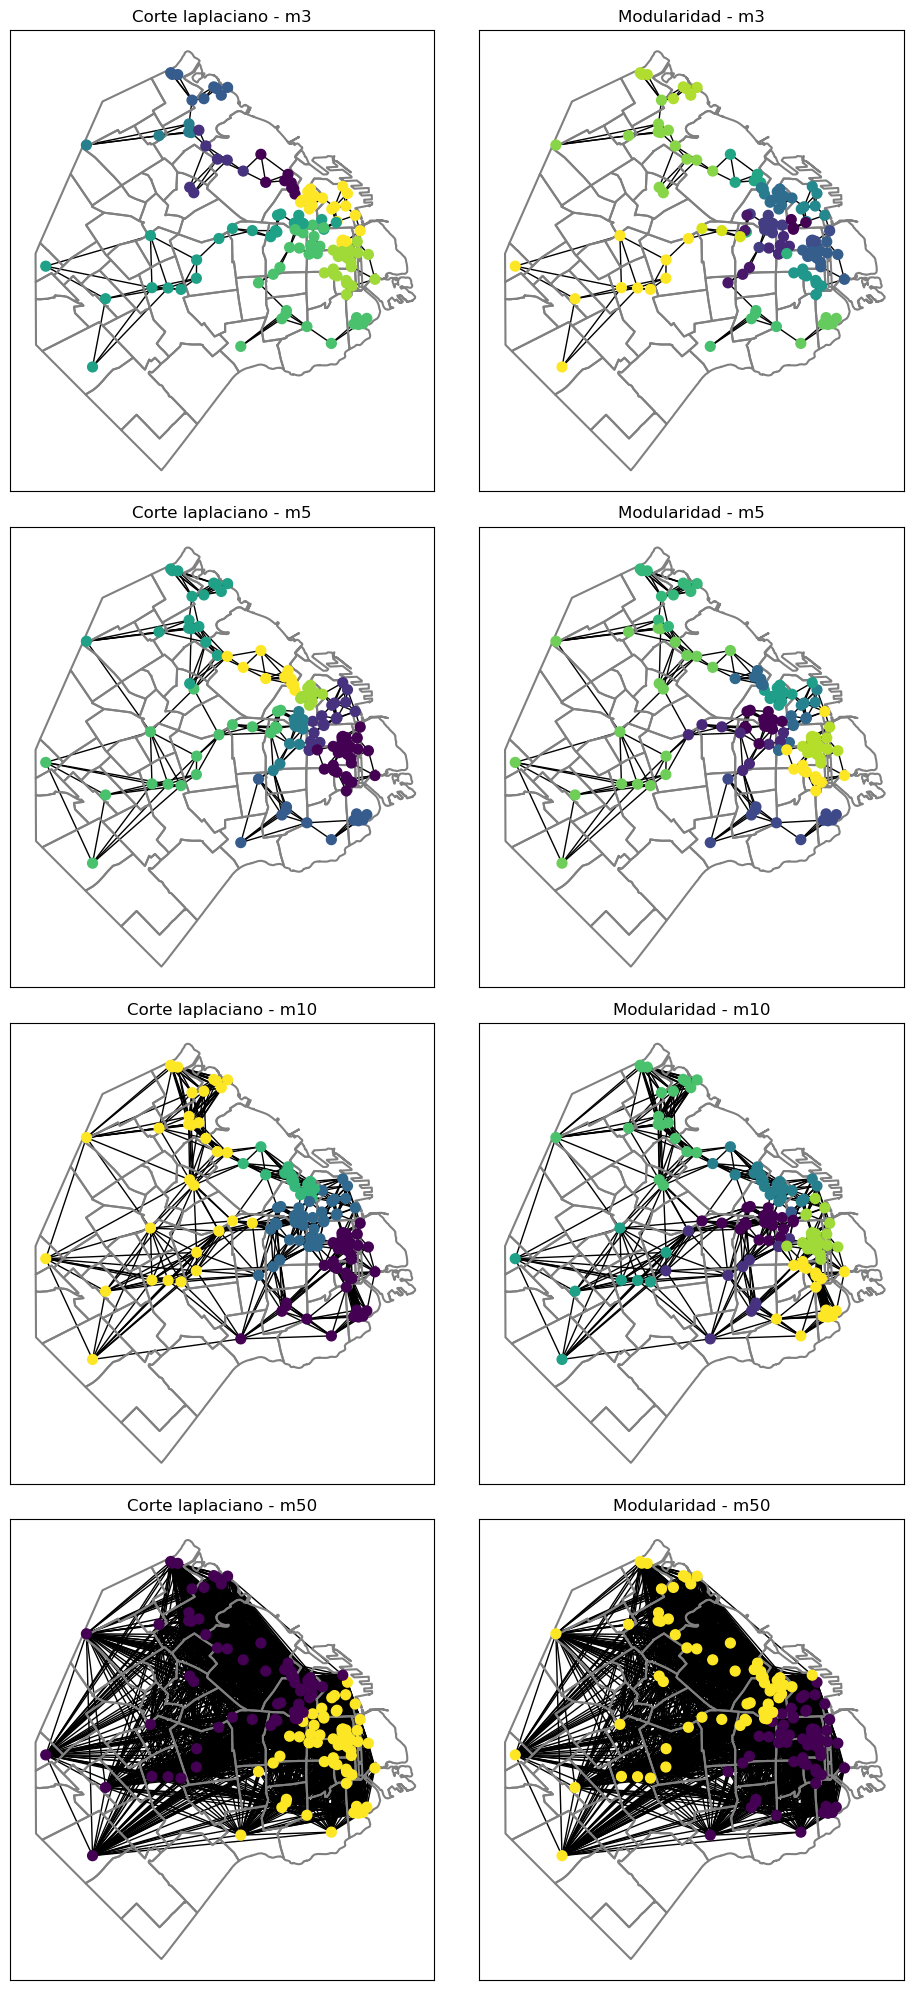

In [26]:
A_m3 = simetrizar(construye_adyacencia(D, 3))
A_m5 = simetrizar(construye_adyacencia(D, 5))
A_m10 = simetrizar(construye_adyacencia(D, 10))
A_m50 = simetrizar(construye_adyacencia(D, 50))

fig, axs = plt.subplots(4, 2, figsize=(14, 20), tight_layout=False)
plotLaplaciano(A_m3, axs[0, 0], 3, "Corte laplaciano - m3")
plotModularizado(A_m3, axs[0, 1], "Modularidad - m3")

plotLaplaciano(A_m5, axs[1, 0], 3, "Corte laplaciano - m5")
plotModularizado(A_m5, axs[1, 1], "Modularidad - m5")

plotLaplaciano(A_m10, axs[2, 0], 2, "Corte laplaciano - m10")
plotModularizado(A_m10, axs[2, 1], "Modularidad - m10")

plotLaplaciano(A_m50, axs[3, 0], 1, "Corte laplaciano - m50")
plotModularizado(A_m50, axs[3, 1], "Modularidad - m50")


Vemos a partir de los distintos resultados obtenidos que en el método de la modularidad la cantidad de cortes disminuye formando clusters de mayor volumen a medida que aumentan la cantidad de adyacencias hasta terminar convergiendo en 2 grandes grupos. En el método laplaciano, dada una cantidad de cortes acorde, la cual va a estar regida por la cantidad de adyacencias ya que estas van a terminar modificando la cantidad de cortes en el metodo de la modularidad y por lo tanto tambien la cantidad respectiva en el metodo del laplaciano para poder compararlos correctamente, vemos agrupaciones similares a las del metodo de la modularidad. Esto se aprecia mas a medida que aumentan las adyacencias, para niveles bajos hay mas diferencias entre las comunidades formadas por los los metodos.

Para el metodo del Laplaciano en particular, observamos que a una cantidad de cortes altos se obtienen particiones mas sensibles a los cambios ya que son mas pequenias y por lo tanto el resultado es inestable, se vuelve mas dificil poder sacar conclusiones con una cantidad alta de cortes ya que los grupos en el grafico se entremezclan y no tienen fronteras claras. Para valores de cortes mas bajos en cambio obtenemos menos grupos pero mucho mas voluminosos y con delimitaciones mas faciles de identificar.

En el metodo de la modularidad en particular se obtienen muchos grupos pequenios si la cantidad de adyacencias es baja, y estos a medida que aumentan las adyacencias disminuyen en cantidad y crecen en tamanio, los grupos tienden a fusionarse hasta armar dos grandes grupos bien definidos. Observamos que los cortes crecen de manera inversamente a la cantidad de adyacencias del grafo, esto porque por definicion del metodo, cuanto mas conectados esten los nodos entre si (una mayor cantidad de aristas), conviene agrupar en menos comunidades para maximizar la modularidad global.

Podemos entonces llegar a una conclusion, aunque para una cantidad de cortes acorde ambos metodos llegan a resultados similares, estos tienen distintos propositos o enfoques, en el metodo de la modularidad se explora la cantidad de grupos en funcion de la cantidad de adyacencias en el grafo, mientras que en el laplaciano los grupos y la cantidad van a estar definidos en funcion de la cantidad arbitraria de cortes que decidamos, pero como vimos esta es sensible a variaciones si elegimos valores muy altos o podemos terminar quedandonos solo con los grupos mas grandes para valores muy bajos, por lo tanto, como podemos definir bajo un rango de cortes que nos pueda brindar mas informacion? podemos complementar el uso de ambos utilizando primero el metodo de la modularidad para identificar cuantos grupos se forman en el grafo para esa cantidad especifica de adyacencias y luego utilizar la cantidad de cortes generados como input para el metodo del laplaciano


## Punto 5.




### Síntesis Final
En ambos trabajos pudimos observar influencias y extraer información a partir de un dataset de museos utilizando diferentes herramientas del algebra lineal. Estas nos permitieron ver cómo se ven afectados los comportamientos del grafo a partir de la variacion de ciertos parámetros. 

Pudimos aprender de los métodos utilizados en la primera parte que el PageRank es áltamente sensible a la elección de parámetros variables que no dependen del dataset como puede ser la cantidad de adyacencias (m) o la aleatoriedad del surfer (alpha), entonces para obtener un análisis útil hay que considerar las distintas combinaciones de las variables y elegir las adecuadas para obtener el resultado mas fidedigno. Un ejemplo de esto sería que si se mantienen fijas las adyacencias y se aumenta la aleatoriedad del "surfer" se observará una repartición más equilibrada de visitantes entre museos, aunque tiende a conservar el orden de los rankings (quien estaba primero con un alpha bajo sigue estando en los primeros puestos con un alpha alto). Por lo que podemos ver que el PageRank, aunque útil, tiene dependencia de valores arbitrarios que no dependen del dataset y que quedan a eleccion de la persona que realiza el estudio, por lo que es dificil de conseguir un PageRank "ideal".

En el TP2, pudimos aprender que el metodo de modularizacion, el cual sirve para distinguir clusters en un dataset, es sensible a la cantidad de adyacencias. Un ejemplo de esto se puede ver cuando, a medida que aumentan las adyacencias, el metodo de subdivision por modularidad genera menor cantidad de grupos. Mientras que en el método del laplaciano cuando se elige una cantidad de cortes acorde a la de la modularidad, la distribución de los grupos en ambos es similar. Esto tiene sentido ya que el objetivo de ambos métodos es poder obtener los clusters de la matriz de adyacencia, lo cual nos sirve para poder distinguir bajo qué conjuntos se suele mantener la gente a medida que se trasladan de museo.

Ambos trabajos se pueden complementar, ya que el PageRank sirve para ver individualmente que museos son los mas visitados mientras que con el metodo de modularidad o laplaciano sirve para ver agrupaciones de los mismos en clusters, por lo que utilizando ambos metodos podriamos ver no solo como interactuan los visitantes con los museos a un nivel individual sino tambien con comunidades de museos 

En síntesis, ambos trabajos prácticos nos otorgaron las herramientas necesarias para poder extraer información y sacar conclusiones a partir de un dataset utilizando métodos matriciales, aunque estos métodos no sean infalibles y sean sensibles o cambien a partir de la elección arbitraria de parámetros. Por lo que para poder llevar a cabo un análisis exhaustivo y poder sacar conclusiones deberiamos considerar un rango amplio de valores para los parámetros de los distintos métodos, tanto para observar cómo estos afectan al resultado como para no sacar conclusiones erroneas a partir de valores arbitrarios.